In [73]:
# Import neccessary library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Import Seasonality - Trend decomposition
from statsmodels.tsa.seasonal import STL

# Import model
from xgboost import XGBRegressor
from prophet import Prophet

# Import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [24]:
# Read data from csv file and make a data frame
orders = pd.read_csv("./datasets/restaurant-1-orders.csv")
orders

,Order Number,Order Date,Item Name,Quantity,Product Price,Total products
0,16118,03/08/2019 20:25,Plain Papadum,2,0.80,6
1,16118,03/08/2019 20:25,King Prawn Balti,1,12.95,6
2,16118,03/08/2019 20:25,Garlic Naan,1,2.95,6
3,16118,03/08/2019 20:25,Mushroom Rice,1,3.95,6
4,16118,03/08/2019 20:25,Paneer Tikka Masala,1,8.95,6
...,...,...,...,...,...,...
74813,2518,18/05/2016 18:53,House Red wine 75cl,2,17.95,7
74814,2503,14/05/2016 19:28,House Red wine 75cl,2,17.95,6
74815,2467,10/05/2016 13:18,House Red wine 75cl,2,17.95,9
74816,2249,07/04/2016 19:04,House white wine 75cl,1,17.95,6


In [25]:
# Check NaN value of dataset
orders.isna().sum()

Order Number      0
Order Date        0
Item Name         0
Quantity          0
Product Price     0
Total products    0
dtype: int64

In [26]:
# Describe the dataset
orders.describe()

,Order Number,Quantity,Product Price,Total products
count,74818.000000,74818.000000,74818.000000,74818.000000
mean,9115.638162,1.243564,5.286492,6.931434
std,4052.210452,0.798207,3.338221,3.954832
min,630.000000,1.000000,0.500000,1.000000
25%,5590.000000,1.000000,2.950000,5.000000
50%,9103.000000,1.000000,3.950000,6.000000
75%,12630.000000,1.000000,8.950000,8.000000
max,16118.000000,51.000000,17.950000,60.000000


In [27]:
# Get the info of each column
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74818 entries, 0 to 74817
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Order Number    74818 non-null  int64  
 1   Order Date      74818 non-null  object 
 2   Item Name       74818 non-null  object 
 3   Quantity        74818 non-null  int64  
 4   Product Price   74818 non-null  float64
 5   Total products  74818 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 3.4+ MB


In [28]:
# Convert the order date column to the datetime
orders['Order Date'] = pd.to_datetime(orders['Order Date'], dayfirst=True)
orders

,Order Number,Order Date,Item Name,Quantity,Product Price,Total products
0,16118,2019-08-03 20:25:00,Plain Papadum,2,0.80,6
1,16118,2019-08-03 20:25:00,King Prawn Balti,1,12.95,6
2,16118,2019-08-03 20:25:00,Garlic Naan,1,2.95,6
3,16118,2019-08-03 20:25:00,Mushroom Rice,1,3.95,6
4,16118,2019-08-03 20:25:00,Paneer Tikka Masala,1,8.95,6
...,...,...,...,...,...,...
74813,2518,2016-05-18 18:53:00,House Red wine 75cl,2,17.95,7
74814,2503,2016-05-14 19:28:00,House Red wine 75cl,2,17.95,6
74815,2467,2016-05-10 13:18:00,House Red wine 75cl,2,17.95,9
74816,2249,2016-04-07 19:04:00,House white wine 75cl,1,17.95,6


In [29]:
# Get the total order of each date
orders_quantity_by_date = orders[['Order Date', 'Quantity']].resample('D', on='Order Date').sum().reset_index()
orders_quantity_by_date

,Order Date,Quantity
0,2015-09-01,1
1,2015-09-02,0
2,2015-09-03,0
3,2015-09-04,0
4,2015-09-05,0
...,...,...
1428,2019-07-30,100
1429,2019-07-31,87
1430,2019-08-01,65
1431,2019-08-02,132


In [30]:
# Find the min value of order date
min_date = orders_quantity_by_date['Order Date'].min()
min_date

Timestamp('2015-09-01 00:00:00')

In [31]:
# Find the max value of order date
max_date = orders_quantity_by_date['Order Date'].max()
max_date

Timestamp('2019-08-03 00:00:00')

In [32]:
# Get the top 5 most sold dish
top_5_dish = orders[['Item Name', 'Quantity']].groupby(by='Item Name').sum().sort_values(by='Quantity', ascending=False)
top_5_dish.head(5)

,Quantity
Item Name,
Plain Papadum,10648
Pilau Rice,6367
Plain Naan,4983
Garlic Naan,3318
Plain Rice,2964


In [33]:
# Return the 5 least sold products
top_5_dish.tail(5)

,Quantity
Item Name,
Chicken Chaat Main,1
Lamb Persian,1
Kurma,1
Mushroom - Prawn,1
Tandoori Chicken,1


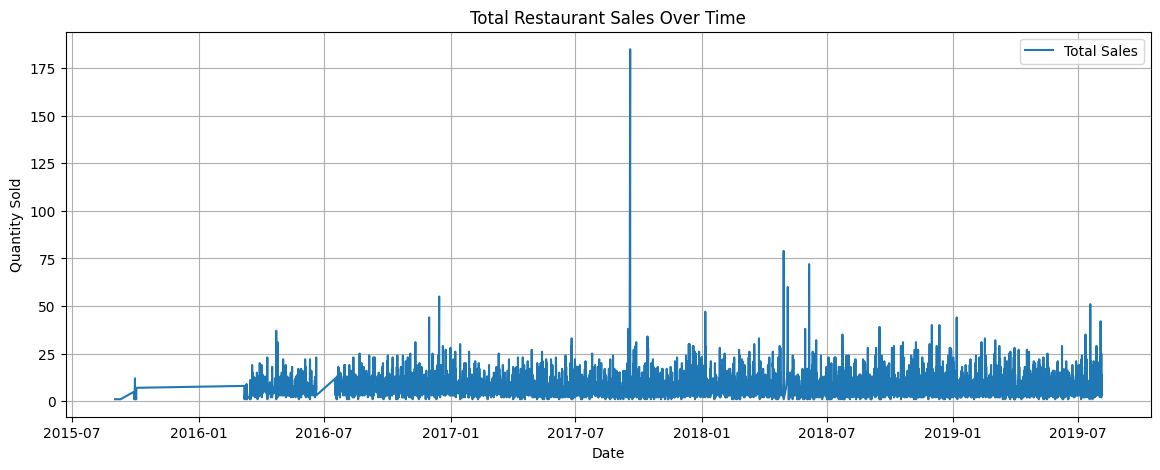

In [50]:
# Visualize daily sale
daily_sales = orders.groupby(by = 'Order Date')['Quantity'].sum().reset_index()
plt.figure(figsize=(14, 5))
plt.plot(daily_sales['Order Date'], daily_sales['Quantity'], label='Total Sales')
plt.title("Total Restaurant Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.grid(True)
plt.legend()
plt.show()

In [51]:
# Find missing day
full_range = pd.date_range(start=min_date, end=max_date)
missing = set(full_range) - set(orders['Order Date'].unique())
print(f'Count of missing day: {len(missing)}')

Count of missing day: 1433


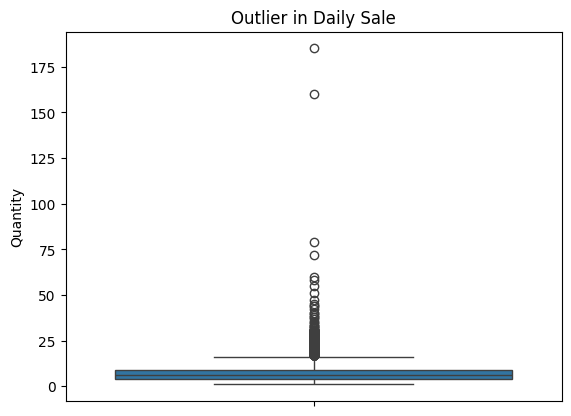

In [52]:
# Visualize the outlier
sns.boxplot(data=daily_sales, y='Quantity')
plt.title('Outlier in Daily Sale')
plt.show()

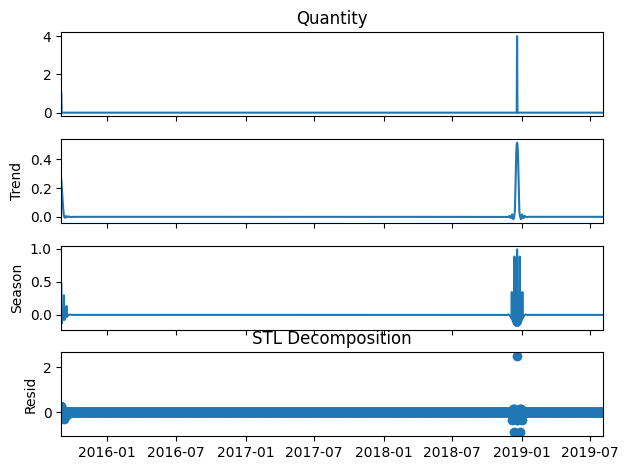

In [53]:
# Seasonality and trend decomposition
daily_sales = daily_sales.set_index('Order Date')
daily_sales = daily_sales.asfreq('D', fill_value=0)  # Fill missing days with 0
stl = STL(daily_sales['Quantity'], period=7)
res = stl.fit()
res.plot()
plt.title('STL Decomposition')
plt.show()

In [54]:
# Let make the histogram to see the distribution order of each year.
# Add the column Year and Month
orders['Year'] = orders['Order Date'].dt.year
orders['Month'] = orders['Order Date'].dt.month

# Return Month/Year data frame
month_year_df = orders.groupby(['Year', 'Month'])['Quantity'].sum().reset_index()
month_year_df

,Year,Month,Quantity
0,2015,9,39
1,2015,10,41
2,2016,3,690
3,2016,4,1168
4,2016,5,1280
5,2016,6,780
6,2016,7,606
7,2016,8,1416
8,2016,9,1468
9,2016,10,2088


C:\Users\famsu\AppData\Local\Temp\ipykernel_3152\3204304985.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby('Month')['Quantity'].sum().reset_index()
C:\Users\famsu\AppData\Local\Temp\ipykernel_3152\3204304985.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby('Month')['Quantity'].sum().reset_index()
C:\Users\famsu\AppData\Local\Temp\ipykernel_3152\3204304985.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the 

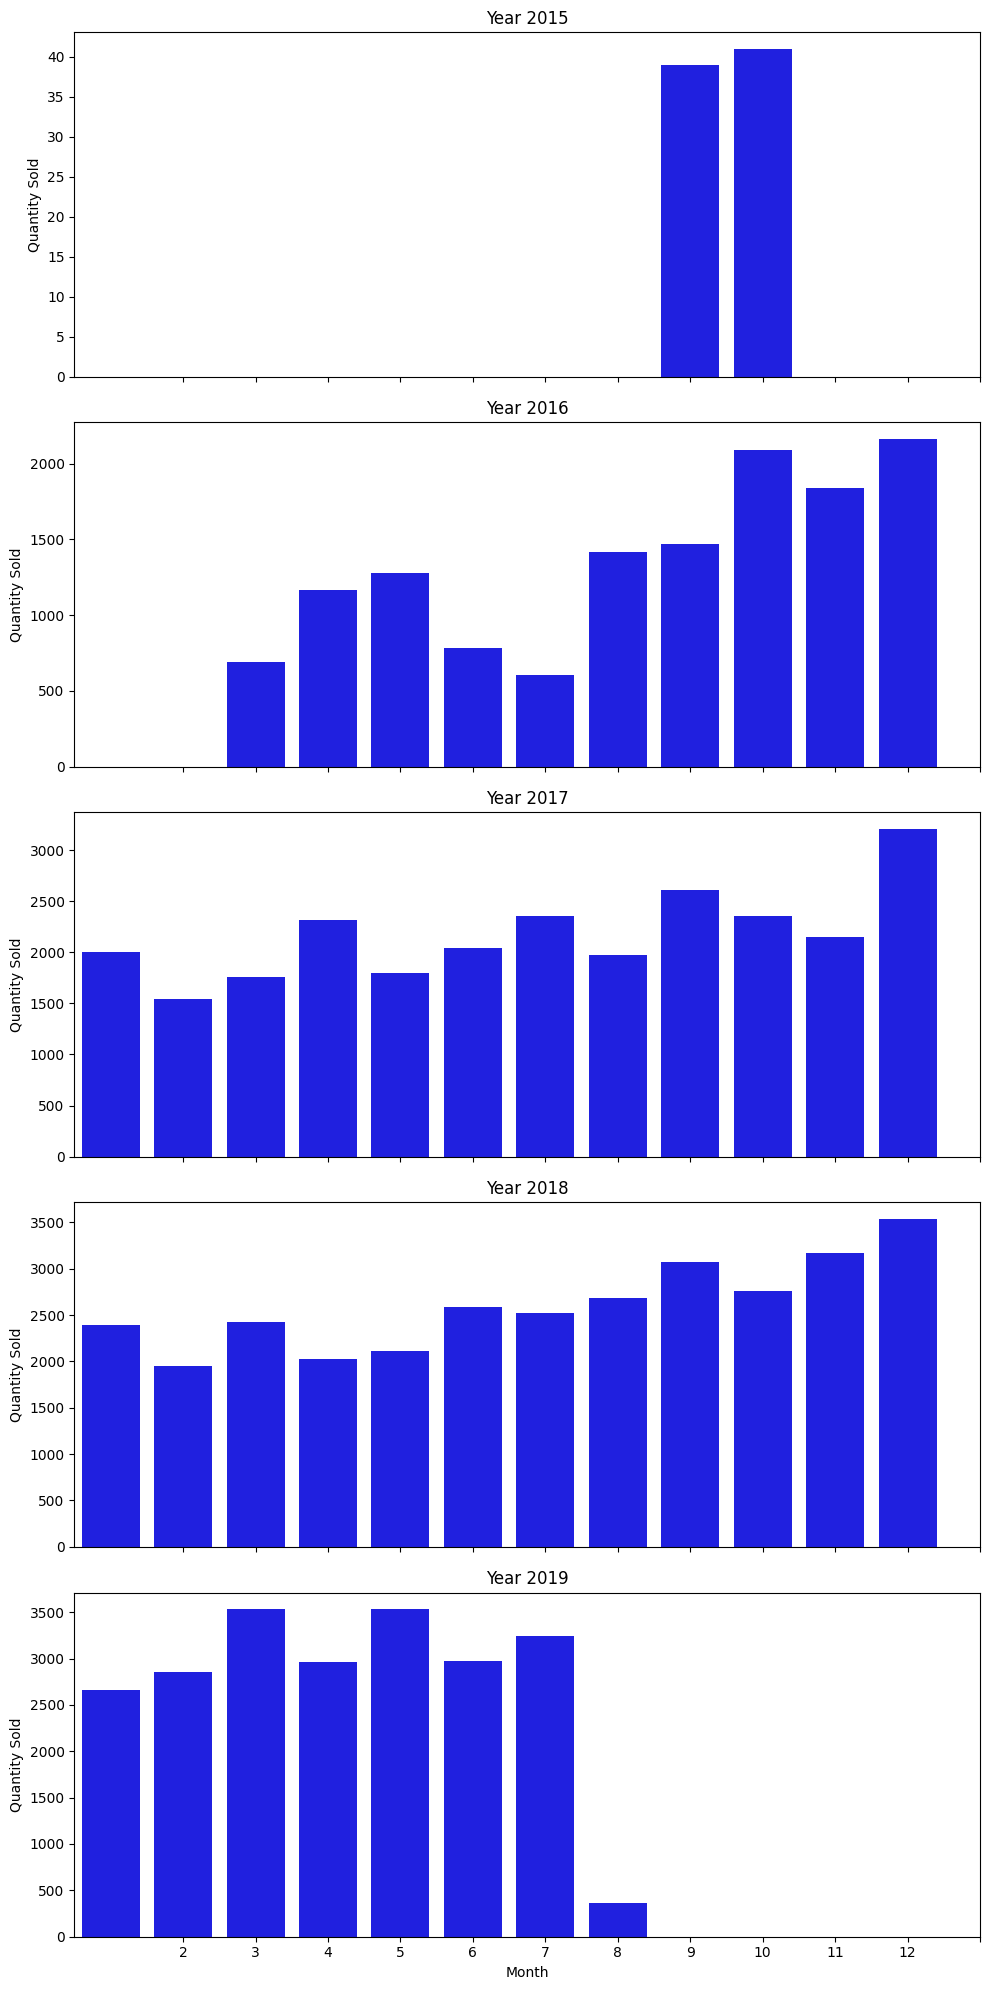

In [55]:
# Visualize the sale distribution by month
month_year_df['Month'] = pd.Categorical(
    month_year_df['Month'], categories=range(1, 13), ordered=True
)
years = month_year_df['Year'].unique()
num_years = len(years)
fig, axes = plt.subplots(nrows=num_years, ncols=1, figsize=(10, num_years * 4), sharex=True)
bin_edges = np.linspace(0.5, 12.5, 13)
for i, year in enumerate(years):
    ax = axes[i]
    data = month_year_df[month_year_df['Year'] == year]
    # sns.histplot(data, x='Month', weights='Quantity', bins=12, kde=True, ax=ax, color='skyblue')
    # Use the histoplot to visualisation the distribution. Got the issue with display the histogram. Some bars are thin or thick
    # The visualization show the 
    # ax.bar(data['Month'], data['Quantity'], color='skyblue')
    grouped = data.groupby('Month')['Quantity'].sum().reset_index()
    sns.barplot(data=grouped, x='Month', y='Quantity', ax=ax, color='blue')

    ax.set_title(f"Year {year}")
    ax.set_xlabel("Month")
    ax.set_ylabel("Quantity Sold")
    ax.set_xticks(range(1, 13))  # Ensure months are labeled correctly

plt.tight_layout()
plt.show()

C:\Users\famsu\AppData\Local\Temp\ipykernel_3152\2965612546.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  month_year_df.groupby('Month')['Quantity'].mean().plot(kind='bar')


<Axes: xlabel='Month'>

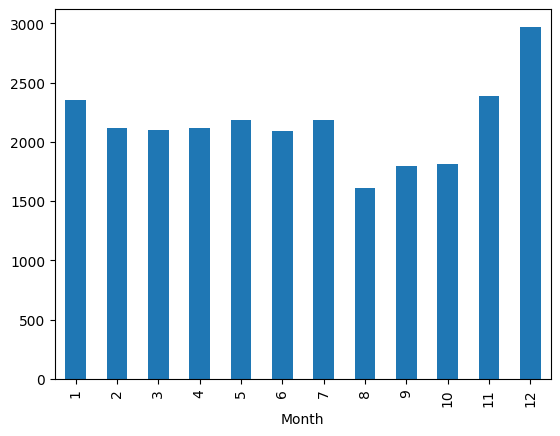

In [56]:
# Show the most sold month by avg
month_year_df.groupby('Month')['Quantity'].mean().plot(kind='bar')
# From the histogram, we can see, that December has the most sold by avg.

In [66]:
# Use prophet model to predict future sale
prophet_df = orders.groupby(by='Order Date')['Quantity'].sum().reset_index()
# Fill the missing date with 0 (currently, do not count the problem of data lost)
full_range = pd.date_range(start=prophet_df['Order Date'].min(), end=prophet_df['Order Date'].max(), freq='D')
prophet_df = prophet_df.set_index('Order Date').reindex(full_range, fill_value=0).reset_index()
prophet_df = prophet_df.rename(columns={'index': 'ds', 'Quantity': 'y'})
prophet_train = prophet_df[:-7]
prophet_test = prophet_df[-7:]

# Create model and train
prophet_model = Prophet()
prophet_model.fit(prophet_train)

20:39:29 - cmdstanpy - INFO - Chain [1] start processing
20:39:30 - cmdstanpy - INFO - Chain [1] done processing


In [83]:
prophet_future = prophet_model.make_future_dataframe(periods=7)
forecast = prophet_model.predict(prophet_future)
predicted = forecast.set_index('ds').loc[prophet_test['ds']]['yhat'].values
actual = prophet_test['y'].values

prophet_rmse = mean_squared_error(actual, predicted)
print("Prophet RMSE:", prophet_rmse)

Prophet RMSE: 8.242312367110711e-05


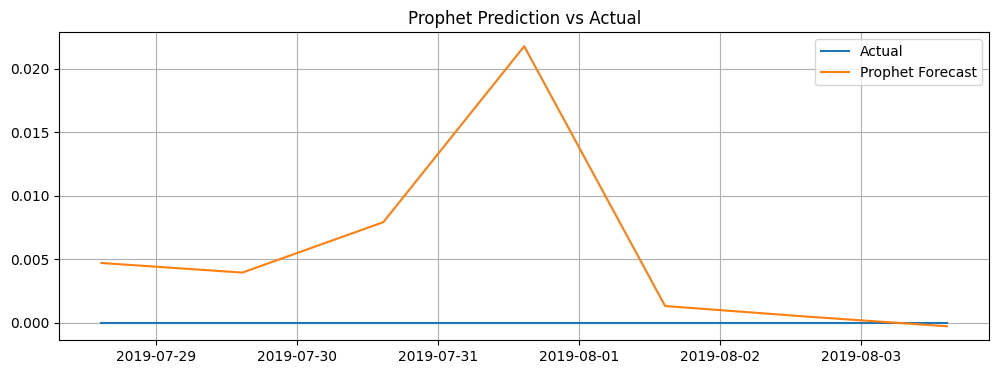

In [91]:
# Visualization the prediction
# Prophet
plt.figure(figsize=(12, 4))
plt.plot(prophet_test['ds'], actual, label='Actual')
plt.plot(prophet_test['ds'], predicted, label='Prophet Forecast')
plt.title("Prophet Prediction vs Actual")
plt.legend()
plt.grid(True)
plt.show()

In [82]:
# Create dataset for xgboost model
xgb_df = orders.groupby('Order Date')['Quantity'].sum().reset_index()

# Add additional columns like day, month, weekday
xgb_df['day'] = xgb_df['Order Date'].dt.day
xgb_df['month'] = xgb_df['Order Date'].dt.month
xgb_df['weekday'] = xgb_df['Order Date'].dt.weekday

# Add lag features
xgb_df['lag_1'] = xgb_df['Quantity'].shift(1)
xgb_df['lag_7'] = xgb_df['Quantity'].shift(7)

# Split
X = xgb_df[['day', 'month', 'weekday', 'lag_1', 'lag_7']]
y = xgb_df['Quantity']

X_train, X_test = X[:-7], X[-7:]
y_train, y_test = y[:-7], y[-7:]

model_xgb = XGBRegressor(early_stopping_rounds=30, n_estimators=700, learning_rate=0.2)
model_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=30,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=700,
             n_jobs=None, num_parallel_tree=None, ...)

In [85]:
y_pred_xgb = model_xgb.predict(X_test)
xgb_rmse = mean_squared_error(y_test, y_pred_xgb)
print("XGBoost RMSE:", xgb_rmse)

XGBoost RMSE: 10.857197761535645


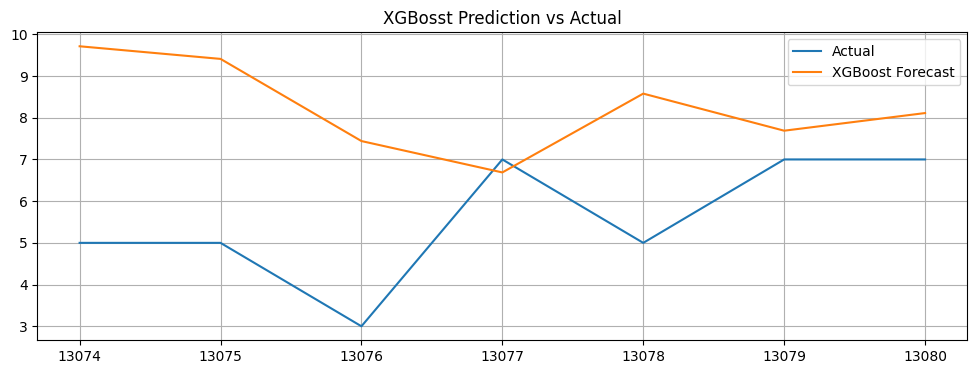

In [90]:
# Visualization the prediction
# XGBoost
plt.figure(figsize=(12, 4))
plt.plot(X_test.index, y_test.values, label='Actual')
plt.plot(X_test.index, y_pred_xgb, label='XGBoost Forecast')
plt.title("XGBosst Prediction vs Actual")
plt.legend()
plt.grid(True)
plt.show()

,day,month,weekday,lag_1,lag_7
13074,3,8,5,4.0,14.0
13075,3,8,5,5.0,3.0
13076,3,8,5,5.0,4.0
13077,3,8,5,3.0,25.0
13078,3,8,5,7.0,12.0
13079,3,8,5,5.0,9.0
13080,3,8,5,7.0,4.0
